### Clustering

In [17]:
import re
import random
import spacy
import numpy as np
import itertools
import collections
import functools
import operator
import matplotlib.pyplot as plt
import dill as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import euclidean_distances

Load data

In [18]:
def load_data(path):
    func_names = []
    func_types = []
    func_comments = []
    with open(path, "r") as file:
        for name, types, comments in (x for x in map(lambda l: l.strip().split("|"), file.readlines()) if len(x) == 3):
            func_types.append(types.split(","))
            func_comments.append(comments.split(","))
            func_names.append(name)
    return func_names, func_types, func_comments

def printk(funcs, k=10, show_sort=True, nmap=None, rand=False):
    print(f"#funcs={len(funcs)}\nfuncs:")
    indices = random.choices(range(len(funcs)), k=k) if rand else range(k)
    print(*((funcs[i], nmap[funcs[i]]) if nmap else funcs[i] for i in indices), sep='\n')
    if show_sort:
        print("\nsorted:", *((f, nmap[f]) if nmap else f for f, _ in zip(sorted(funcs), range(k))), sep='\n')

func_names, func_types, func_comments = load_data("functions.txt")
printk(func_names)

#funcs=3539588
funcs:
Inu_scaled
default_response_type
ComputeNewDominator
set_cost_graph
freednsentry
ti_vsend_sync
k3_dma_probe
CRYP_DataOut
hblank_dma
test_unset_flag

sorted:
$$RTX$$version
$$USBD$$version
$relaytrace$StdcallFunction
$relaytrace$StdcallVersionRange
$relaytrace$Stdcalli386x64
A
A
A
A
A


Drop wrong names

In [19]:
def drop_wrong_names(func_names, func_types, func_comments):
    re_ident = re.compile(rf"^[a-zA-Z_][a-zA-Z_0-9]*$", re.UNICODE)
    func_names, func_types, func_comments = map(
        list, zip(*(itertools.filterfalse(lambda x: not re_ident.fullmatch(x[0]),
                                          zip(func_names, func_types, func_comments)))))
    return func_names, func_types, func_comments

func_names, func_types, func_comments = drop_wrong_names(func_names, func_types, func_comments)
printk(func_names)

#funcs=3521880
funcs:
Inu_scaled
default_response_type
ComputeNewDominator
set_cost_graph
freednsentry
ti_vsend_sync
k3_dma_probe
CRYP_DataOut
hblank_dma
test_unset_flag

sorted:
A
A
A
A
A
A
A
A
A
A


Split names to tokens

In [20]:
def tokenize_funcs(funcs):
    oneword = re.compile(r"^[a-z][a-z0-9]+|[A-Z][A-Z0-9]$")
    difCase = re.compile(r".+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)")
    under_scores_split = re.compile(r"_")

    tokenized_funcs = []
    for f in funcs:
        if oneword.fullmatch(f):
            tokenized_funcs.append([f])
        elif "_" in f:
            tokenized_funcs.append([w for w in under_scores_split.split(f) if w])
        else:
            tokenized_funcs.append([w.group(0) for w in difCase.finditer(f) if w.group(0)])
    return tokenized_funcs

tokenized_func_names = tokenize_funcs(func_names)
tokenized_func_names = [tok_name + tok_comm for tok_name, tok_comm in zip(tokenized_func_names, func_comments)]
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=3521880
funcs:
('dissect_wps_vendor_ext', ['dissect', 'wps', 'vendor', 'ext', ''])
('ipv6_find_tlv', ['ipv6', 'find', 'tlv', ''])
('bindgen_test_layout_RNode__bindgen_ty_3', ['bindgen', 'test', 'layout', 'RNode', 'bindgen', 'ty', '3', ''])
('ar5315_gpio_pin_configure', ['ar5315', 'gpio', 'pin', 'configure', ''])
('operator_offset', ['operator', 'offset', 'map', 'operator', 'number', 'to', 'register', 'offset'])
('do_write', ['do', 'write', ''])
('atmel_pcm_free_dma_buffers', ['atmel', 'pcm', 'free', 'dma', 'buffers', ''])
('non_pawn_material_c', ['non', 'pawn', 'material', 'c', ''])
('pymain_read_conf', ['pymain', 'read', 'conf', 'Read', 'the', 'configuration', 'but', 'initialize', 'also', 'the', 'LC', 'CTYPE', 'locale', 'enable', 'UTF', '8', 'mode', 'PEP', '540', 'and', 'or', 'coerce', 'the', 'C', 'locale', 'PEP', '538'])
('smu7_read_smc_sram_dword', ['smu7', 'read', 'smc', 'sram', 'dword', ''])

sorted:
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', ['A', ''])
('A', 

Drop digits from tokens, convert to low register

In [21]:
def drop_wrong_symbols(func_names, tokenized_func_names, func_types):
    # first approach to drop all digits, second only if > 50%
    wrong_char = re.compile(r"[\d]")
    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [wrong_char.sub("", token).lower() for token in tokenized_name if wrong_char.sub("", token)]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = drop_wrong_symbols(func_names, tokenized_func_names, func_types)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=3521792
funcs:
('destruct_monetary', ['destruct', 'monetary'])
('fmt_02u', ['fmt', 'u', 'does', 'not', 'call', 'guarantee', 'eats', 'into', 'headroom', 'instead'])
('samr_dissect_element_EnumDomains_num_entries', ['samr', 'dissect', 'element', 'enumdomains', 'num', 'entries'])
('_dt_collection_store', ['dt', 'collection', 'store'])
('set80211priv', ['setpriv'])
('team_priority_option_get', ['team', 'priority', 'option', 'get'])
('live_idle_flush', ['live', 'idle', 'flush'])
('StringIsEmptyGeneric', ['string', 'is', 'empty', 'generic'])
('world_obj_get', ['world', 'obj', 'get'])
('glusterd_store_perform_volume_store', ['glusterd', 'store', 'perform', 'volume', 'store'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])


Split concatenated words to separate tokens

In [22]:
def create_segment_func(tokenized_func_names, c=1, base=1/26, prior=1e-8):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    total_num_words = sum(word2count.values())
    corrected_total_num_words = (len(word2count) + 1) * c + total_num_words
    word2prob1 = {k: v / total_num_words for k, v in word2count.items()}
    word2prob2 = {k: (v + c) / corrected_total_num_words for k, v in word2count.items()}
    unseen_prob = c / corrected_total_num_words
    ones_length2count = collections.Counter(map(len, (word for word, count in word2count.items() if count == 1)))
    ones_longest = max(ones_length2count)
    ones_num_words = sum(ones_length2count.values())

    # naive probability v1
    def prob1(word):
        return word2prob1[word]

    # smoothed probability v1
    def prob2(word):
        return word2prob2[word] if word in word2prob2 else unseen_prob

    # smoothed probability v2
    def prob3(word):
        unseen_estimation = ones_length2count[len(word)] / ones_num_words if len(word) in ones_length2count \
            else ones_length2count[ones_longest] / ones_num_words * base ** (len(word) - ones_longest) \
            if len(word) > ones_longest else base ** len(word)
        return word2prob1[word] if word in word2prob1 else prior * unseen_estimation

    with open("prob3.pickle", "wb") as f:    
        pickle.dump(prob3, f)

    def split(word, start=1, end=20):
        return ((word[:i], word[i:]) for i in range(start, min(len(word) + 1, end)))

    @functools.lru_cache(maxsize=10000)
    def segment(word, maxlen=500):
        if not word:
            return []
        if len(word) > maxlen:
            return segment(word[:maxlen]) + segment(word[maxlen:]) 
        candidates = ([first] + segment(remaining) for first, remaining in split(word))
        return max(candidates, key=lambda x: functools.reduce(operator.__mul__, map(prob3, x), 1))
    return segment

def segmentize_corpus(tokenized_func_names, segmenter):
    tokenized_func_names = [list(itertools.chain(*(segmenter(token) for token in tokens)))
                            for tokens in tokenized_func_names]
    return tokenized_func_names

segmenter = create_segment_func(tokenized_func_names)
words = ["ccfileutils", "setendframeindex", "inneractionframe", "setsearchresolutionsorder",
         "dynamicmeminit", "wakeupiodisableglobal", "getinit", "getinitz"]
print(*((word, segmenter(word)) for word in words), "", sep='\n')
tokenized_func_names = segmentize_corpus(tokenized_func_names, segmenter)

name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del words, name2tokens

('ccfileutils', ['ccfileutils'])
('setendframeindex', ['setendframeindex'])
('inneractionframe', ['inneractionframe'])
('setsearchresolutionsorder', ['set', 'search', 'resolutions', 'order'])
('dynamicmeminit', ['dynamicmeminit'])
('wakeupiodisableglobal', ['wakeupiodisable', 'global'])
('getinit', ['get', 'init'])
('getinitz', ['get', 'init', 'z'])

#funcs=3521792
funcs:
('fubyte_slow0', ['fubyte', 'slow', 'fetch', 'load', 'a', 'bit', 'word', 'a', 'bit', 'word', 'or', 'an', 'bit', 'byte', 'from', 'user', 'memory'])
('gtk_pizza_get_type', ['gtk', 'pizza', 'get', 'type'])
('isLoopStructureUnderstood', ['is', 'loop', 'structure', 'understood'])
('Discord_RegisterW', ['discord', 'register', 'w'])
('lookup_ordermap_10_000_exist_string', ['lookup', 'order', 'map', 'exist', 'string'])
('rpl_get_instance', ['rpl', 'get', 'instance'])
('ieee80211_monitor_rx', ['ieee', 'monitor', 'rx'])
('GetAttackEnemyBaseCmd', ['get', 'attack', 'enemy', 'base', 'cmd'])
('usb6fire_fw_init', ['usbfire', 'fw', '

Lemmatize tokens

In [23]:
print("#uniq tokens before lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")

def lemmatize_corpus(tokenized_func_names):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    lengths = np.cumsum([0] + list(map(len, tokenized_func_names)))
    flat_tokens = list(itertools.chain(*tokenized_func_names))
    doc = spacy.tokens.Doc(nlp.vocab, words=flat_tokens)
    tokenized_func_names = [[token.lemma_ for token in doc[lengths[i - 1]: lengths[i]]]
                            for i in range(1, len(tokenized_func_names) + 1)]
    return tokenized_func_names

tokenized_func_names = lemmatize_corpus(tokenized_func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)

print("\n#uniq tokens after lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")
del name2tokens

#uniq tokens before lemmatizing 336866 

#funcs=3521792
funcs:
('mfi_build_ldio', ['mfi', 'build', 'ldio'])
('delete_user', ['delete', 'user'])
('pq16_get_src', ['pq', 'get', 'src'])
('A5XX_CP_EXEC_CS_INDIRECT_3_LOCALSIZEX', ['axx', 'cp', 'exec', 'c', 'indirect', 'localsizex'])
('tvh_context_handle', ['tvh', 'context', 'handle'])
('dmi_table', ['dmi', 'table'])
('is_valid_initial_branch_character', ['be', 'valid', 'initial', 'branch', 'character'])
('free_pd', ['free', 'pd'])
('setIsDiscendentOrder', ['set', 'be', 'discendent', 'order'])
('wa_write_clr_set', ['wa', 'write', 'clr', 'set'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])

#uniq tokens after lemmatizing 326946 



Drop rare or uninformative tokens

dict size: 50418

dict:
('set', 334762)
('this', 333053)
('if', 320909)
('from', 222260)
('use', 218019)
('mut', 212692)
('value', 211379)
('let', 205689)
('not', 198124)
('test', 197715)

reversed dict:
('xircps', 10)
('mtod', 10)
('kdtrace', 10)
('playstation', 10)
('enotempty', 10)
('tdk', 10)
('reencrypt', 10)
('resetted', 10)
('multid', 10)
('amdstd', 10)


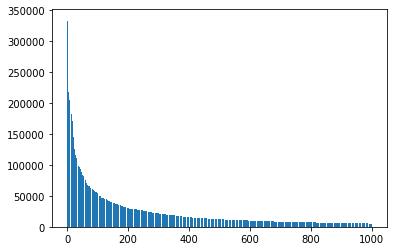

In [37]:
def prune_vocabulary(func_names, tokenized_func_names, func_types, max_ct=335e3, min_ct=10, min_len=2, max_len=20):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    word2count = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)
                  if min_ct <= v <= max_ct and min_len <= len(k) <= max_len}
    vocab_low_to_high = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=False)}
    print(f"dict size: {len(word2count)}\n\ndict:")
    print(*((k, v) for _, (k, v) in zip(range(10), word2count.items())), "\nreversed dict:", sep='\n')
    print(*((k, v) for _, (k, v) in zip(range(10), vocab_low_to_high.items())), sep='\n')

    word2ind = {w: i for w, i in zip(word2count.keys(), itertools.count())}
    ind2count = {word2ind[w]: freq for (w, freq), _ in zip(word2count.items(), range(1000))}
    plt.bar(ind2count.keys(), ind2count.values())
    plt.show()

    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [token for token in tokenized_name if token in word2count]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = prune_vocabulary(func_names, tokenized_func_names, func_types)

Process types

In [38]:
def tokenize_types(func_types):
    type_set = {
        "int", "unsigned int", "char", "unsigned char", "enum", "struct", "void", "long", "unsigned long",
        "float", "double", "short", "unsigned short", "bool", "union", "long long", "unsigned long long"}
    type_dict = {re.compile(t): t for t in type_set}
    re_drop = re.compile(r"\*|restrict|const")
    struct_type = re.compile("struct")
    tokenized_types = [[0 for _ in range(len(f_types))] for f_types in func_types]
    for i, f_types in enumerate(func_types):
        for j, type in enumerate(f_types):
            cleaned_type = re_drop.sub("", type)
            for re_t, t in type_dict.items():
                if re.search(re_t, cleaned_type):
                    tokenized_types[i][j] = t
                    break
            else:
                tokenized_types[i][j] = type_dict[struct_type]
    return tokenized_types

print(*(func_types[i] for i in range(10)), sep='\n')
tokenized_func_types = tokenize_types(func_types)
print("\n", *(tokenized_func_types[i] for i in range(10)), sep='\n')

['struct', 'double', 'double']
['struct', 'struct']
['int *', 'int *', 'int *']
['struct', 'struct']
['void', 'void *']
['int', 'struct usb_device *', 'int', 'int', 'int', 'void *', 'int', 'int']
['int', 'struct platform_device *']
['int']
['struct', 'struct']
['struct']


['struct', 'double', 'double']
['struct', 'struct']
['int', 'int', 'int']
['struct', 'struct']
['void', 'void']
['int', 'struct', 'int', 'int', 'int', 'void', 'int', 'int']
['int', 'struct']
['int']
['struct', 'struct']
['struct']


Construct feature matrix

In [39]:
max_samples = int(1e7)
num_samples = min(max_samples, len(func_names))
func_names, tokenized_func_names, func_types, tokenized_func_types = zip(*(random.sample(
    list(zip(func_names, tokenized_func_names, func_types, tokenized_func_types)), k=num_samples)))
tokenized_features = [tok_name + tok_types for tok_name, tok_types in zip(tokenized_func_names, tokenized_func_types)]
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, sublinear_tf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_features)
np.save("idf", tfidf_vectorizer.idf_)
with open("vocabulary.pickle", "wb") as f:
    pickle.dump(tfidf_vectorizer.vocabulary_, f)
print(tfidf_matrix.shape)

(3471763, 50420)


Clustering

In [42]:
n_clusters = 500
n_init = 5
model = KMeans(n_clusters=n_clusters, n_init=n_init)
predictions = model.fit_predict(tfidf_matrix)
# isomap = Isomap(n_components=2)
# transformed = isomap.fit_transform(tfidf_matrix)
# x_axis = transformed[:, 0]
# y_axis = transformed[:, 1]
# plt.scatter(x_axis, y_axis, c=predictions)
# plt.show()
# del transformed, x_axis, y_axis

In [43]:
centers = np.array(model.cluster_centers_)
np.save("centers", centers)
closest_ct = 10
for i in range(n_clusters):
    center = centers[i].reshape(1, -1)
    cluster_indexes = [j for j, cl in enumerate(predictions) if cl == i]
    cluster_funcs = [func_names[j] for j in cluster_indexes]
    cluster_feats = tfidf_matrix[cluster_indexes, :]
    cluster_dists = euclidean_distances(cluster_feats, center)
    cluster_closest_indexes = np.argpartition(cluster_dists.reshape(-1), closest_ct)
    print(f"cluster{i + 1}")
    for j in range(closest_ct):
        print(cluster_funcs[cluster_closest_indexes[j]])
    print("")

cluster1
vvwe
wen
reimbursement_and_disbursement_we
qweBCabc0123456xyz
QWE
u3we_leer
qwe
u3we_scot
u3we_lune
wet

cluster2
in_transaction
is_transaction
get_transaction
transaction
transactions
as_transaction
transaction
get_transactions
transaction
transactions

cluster3
GetDouble
Int
get_double
ToDouble
getDouble
f80_to_double
mat3inv_double
double_to_u8
ofToDouble
get_double

cluster4
copy
derva_copy
copy
CopyTo
copy_as
CopyTo
copy
fcopy
CopyTo
copy

cluster5
sock_bufferize
list_core_v1_config_map_for_all_namespaces
h1_headers_to_hdr_list
watch_core_v1_node
list_core_v1_node
watch_core_v1_node_list
list_core_v1_endpoints_for_all_namespaces
watch_core_v1_namespaced_config_map_list
list_core_v1_component_status
list_events_v1beta1_namespaced_event

cluster6
get_triggers
trigger
IsTriggered
trigger
get_trigger
trigger_ss
is_trigger
get_trigger_htstamp
get_triggered
trigger_housekeep

cluster7
i915_gemfs_init
bcmmix_init
init
init_cqcam
th58nvg2s3hbai4_init
tas3001_init
vv6410_init
PyIm

cluster67
Delete
realtimer_delete
delete
NotifyfsDelete
delete_to
to_be_deleted
was_deleted
deleted
delete
OPTEX_Delete

cluster68
value_infos
field_infos
get_type_infos
get_infos
value_infos
get_type_infos
infos
write_infos
get_block_infos
get_block_infos

cluster69
exynos4210_init
exynos_init
exynos5422_asv_init
exynos4210_getc
exynos5422_asv_init
exynos4210_set_busclk
exynos_asv_init
exynos4_dwmci_init
exynos4210_init
exynos4_busfreq_remove

cluster70
Last
GetLast
GetLast
last
Last
Last
GetLast
Last
last
last

cluster71
get_dma
is_dma
dma_w
dma_w
DMA_AbortTransfer
get_xdma_axistream
DMA_GetFreeChannel
dma_r
is_dma32
dma_r

cluster72
k400_allocate
allocate
m560_allocate
allocate
allocate
turnports_allocate
allocate
Allocate
Allocate
allocate

cluster73
load
load
load_binint
GLoad
load_binpersid
load_binfloat
load_persid
load
Load
load_binfloat

cluster74
is_v3_connection
get_connection
connection
connection
GetConnection
GetConnection
connection
get_semaphored_connection
get_connecti

cluster136
cleanup
ichxrom_cleanup
cleanup
esb2rom_cleanup
gphonet_cleanup
netwireless_cleanup
cleanup
cleanup
cleanup
cleanup

cluster137
str_char
str_to_epdisc
mkf_str
efibc_str_to_str16
str_to_str
str_to_str
get_str
get_str_f
str
str_CBaseStorageVariant

cluster138
Increment
increment
get_and_increment
increment_y
increment
incrementing
get_increments
increments
increment_x
increment

cluster139
gimp_eek
gimp_data_is_duplicatable
gimp_logv
gimp_log
gimp_get_geglopclasses
_gimp_config
gimp_unitrc_load
gimp_init_i18n
gimp_wait
gimp_version

cluster140
notify
get_notify
Notify
cs_notify
_notify
notify
notify
hpwl_notify
notify
notify

cluster141
GetPointer
topointer
int8Pointer
getPointer
getPointer
GetPointer
pointer
GetPointer
get_pointer
pointer

cluster142
move_
get_moves
Move
moves
move_in
moving
moved
_move
move
as_move

cluster143
start
vv6410_start
jlj_start
get_start
rtty_start
ioc3aux_start
smcwd_start
is_started
is_started
ALCcaptureAlsa_start

cluster144
max_int
getMax
max_

cluster202
fw_get
fwi08
fwi16
fwi32
fwb32
fwb08
fwb16
to_fw_linkcaps
fwt
FWT

cluster203
proto_register_asphodel
proto_register_j1939
proto_register_btgnss
proto_register_bt3ds
proto_register_mdshdr
proto_register_elcom
proto_register_kismet
proto_register_dtsprovider
proto_register_stanag4607
proto_register_rpcordma

cluster204
zip_is64
zip_is64
Zip_Get
zip
zip_putcurtime
is_zipped
zip_0243
zip
zip_0143
zip_1

cluster205
slots
slot
slot
slot
getSlot
get_slot
slots
GetSlots
get_slot
GetSlot

cluster206
Malloc
iwh_malloc
Z_Malloc
malloc
_int_malloc
x264_malloc
g_malloc0
s_malloc
__x_malloc
k_malloc

cluster207
extractT
extracted
geta
extract
Extract
get_extract
getb
extract
extract
extract

cluster208
kexgex_server
is_server
msock_server
server
server
xdping_server
getServer
GetServer
server
kexc25519_server

cluster209
clear
clear
clear_heatmaps
clear
clear_callValueInfo
clear_disconnectTimes
clear_TotalNetLimit
clear_fetchVariable
clear_aa
clear_communityitemid

cluster210
forget_acqu

cluster270
get_version
version
get_version
version
get_version
version
get_version
get_version
get_version
version

cluster271
init
init_mbeepp
tsuka_init
buttobi_init
init_pnchmn
initn_b
init_qexp
fpconv_init
nfdicf_init
isobus_init

cluster272
arch_gettimeoffset
get_arch
arch_reapChild
getArch
arch_traceDetach
get_arch
arch_setvtor
Arch_postModifyRegisters
arch_traceSignalsInit
arch_perfMmapParse

cluster273
ETH
eth_newBlockFilter
ETH_AcquireFreeTxDesc
eth_gasPrice
eth_awaitNewWork
eth
ETH_AcquireFreeRxDesc
eth_xrp_interoperable
ETH_GetTxDescBufAddr
eth_newFilterEx

cluster274
List
as_int_list
getList
list
efiblk_get_pdinfo_list
list_offramps
c_list
list_onramps
list
get_list

cluster275
turnports_release
WS_Release
z2_release
snlua_release
Release
release_l1
_release
avmcs_release
au8522_release
l64781_release

cluster276
vec4
to_vec_u16
as_vec_f32
get_u16_vec
is_vec
vec_get
to_f64_vec
as_vec
to_vec_i16
as_vec_u32

cluster277
_mouse
mouse_y
mouse
is_mouse
ofGetMouseY
ofGetMouseX
_ge

cluster333
and_a_c
with_redoxfs
with_z
to_rmo_with
struct_with_traitbounds
with_return
with2
with_lcpl
and_a_l
with_subinterval

cluster334
GetAttribute
get_attribute
attributes
getAttribute
attribute
to_attributes
attribute
getAttribute
is_attribute_attribute
attributed

cluster335
mul16
mul
mul32
mul8
mul
mul_u32
mul
mul
muln
mul

cluster336
IsInvalid
invalid_abcs
invalid9
invalid6
invalid_1
invalid_get
Invalid
Invalid
get_invalid
invalid

cluster337
_old_getrpcent
is_old
as_elder
old
e_old
old
get_oldest
oldest
_old_getrpcbynumber
get_oldest

cluster338
and_d8
get_headBlockTimeWeBothHave
has_b0
has_lastPacketInBlock
MarkFail_D_PhyOneBlock
has_lastSegmentTxId
has_newGenStamp
has_d
has_includekvtags
has_issueDate

cluster339
proc_rdagent
proc_getwstat
proc_claiminterface
proc_getlwpstatus
proc_disconnectsignal
Proc_1
proc_clearhalt
proc_get_usblpid
proc_clearhalt
proc_reapurbnonblock

cluster340
Add
get_and_add
add
Add
add32
Add
add
add_y
add
add

cluster341
simple_3
simple_001
simple

cluster398
get_min
int_min
mins
min_y
min
Min
clh_min
MinInt
min
is_min

cluster399
dissect_ain_AMATimeDuration
dissect_ARServerBlock
dissect_z3950_T_resourceChallenges
dissect_p1_ExplicitConversion
dissect_p1_SecurityContext
dissect_h450_7_MWIInterrogateArg
dissect_h225_EncryptIntAlg
dissect_ain_ODisconnectArg
dissect_h245_T_mediaPacketization
dissect_ain_AMALineNumber

cluster400
Destroy
EnumConnectionsImpl_Destroy
ConnectionPointImpl_Destroy
destroy
visiontest_destroy
Destroy
destroy_vpollinfo
shres_destroy
Destroy
x_destroy

cluster401
rtty_exit
get_exit
fqdir_exit
exit
exit
av7110_av_exit
h_exit
cs_exit
childproc_exited
exit

cluster402
chunks
getChunk
get_liveview_chunk
n_chunks
to_chunk
chunks_for_get
chunked
chunk
is_chunked
ws_chunk

cluster403
cmp0022
cmp
cmp
cmp
u32_as_cmp
cmp
int_cmp
cmp
s_vcmp
cmp16

cluster404
player3
getPlayer
get_players
ToHL2MPPlayer
as_player
get_player
ToHL2MPPlayer
player
is_player
player1

cluster405
get_font
GetFont
getFont
font
get_font
GetFont
t

cluster463
get_sameIpMaxConnectCount
p_count
count
get_count
count
get_count
get_count
_get_count
GetCount
get_count

cluster464
get_mac
GetMAC
mac
get_mac
mac_SetMacAddr
mac_SetFrameFilter
mac2u64
wncm14a2a_get_mac
MAC
get_mac

cluster465
n64joy_open
rpckbd_open
fjn_open
h5_open
w5300_open
au1000_open
sctty_open
ts_open
visorinput_open
ptsdrv_open

cluster466
nfs_addmntent
nfs4_get_rootfh
nfs_get_cverf
nfs_kqwatch
NFS_MINATTRTIMEO
nfs_rcvlock
NFS_MAXATTRTIMEO
nfs_endmntent
nfs41_delegpurge
nfs_kqunwatch

cluster467
GetFunc
func
i801_func
Dof6Spring2CreateFunc
au1550_func
sis630_func
sis5595_func
func2
func
func2

cluster468
calc
rdxr_calc
ryxr_calc
calc
calc_f_g
calc_k
calc_authresp
calc
calc_swidthsw
calc_swidthsw

cluster469
pitlb_template
loopgtz_template
retw_n_template
dhwbi_template
licw_template
rdtlb1_template
rfwo_template
beq_template
rfwu_template
retw_template

cluster470
inserts
get_insert
insert_1
insert_and_get_3
inserted
insert_f32
insert_get
insert_and_get_4
insert
in